# Unit 4: Applied Machine Learning 2
## Task 3: Visual search with k-NN
###### Candelaria Retamal
###### **21.06.2022**


#### 3.1. Fit and tune a k-NN classifier
Fit and tune a k-NN classifier. Visualize the train and validation curves

---

> **Solution**: I start by loading the data.

In [1]:
import numpy as np
import os

# Load data
with np.load("features_trainset.npz") as npz_file:
    X_tr = npz_file["data"]
    y_tr = npz_file["label"]

print("X:", X_tr.shape, X_tr.dtype)
print("y:", y_tr.shape, y_tr.dtype)

with np.load("features_testset.npz") as npz_file:
    X_te = npz_file["data"]
    y_te = npz_file["label"]

print("X:", X_tr.shape, X_tr.dtype)
print("y:", y_tr.shape, y_tr.dtype)

print("X:", X_te.shape, X_te.dtype)
print("y:", y_te.shape, y_te.dtype)

X: (280, 1280) float32
y: (280, 6) float32
X: (280, 1280) float32
y: (280, 6) float32
X: (50, 1280) float32
y: (50, 6) float32


In [2]:
# Convert to float
X_tr = X_tr.astype(np.float)
X_te = X_te.astype(np.float)
# Print the new data type
print('dtype:', X_tr.dtype)
print('dtype:', X_te.dtype)

dtype: float64
dtype: float64


I create a k-NN classifier with Pipeline and fit the training dataset.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=6,  # Set k to 6
    # Use the simple 'brute' strategy to find nearest neighbors.
    # It's faster in this case!
    algorithm="brute",
)

# Create the pipeline that uses the knn-classifier 
knn_pipe = Pipeline(
    [
        # ('scaler', StandardScaler()), # With standardization
        ("scaler", None),  # Better performance without standardization!
        ("knn", knn),
    ]
)
# Fit the pipeline to the training data
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)

# Print accuracy
print("k-nearest neighbors (k=6) accuracy: {:.3f}".format(accuracy))

k-nearest neighbors (k=6) accuracy: 0.900


The results show an accuracy of 90% in the training with 6 neighbors.

* Let's now tune the model by using grid search to find the best k values

In [4]:
# Generate a set of k values for iteration
k_values = np.arange(1, 30, 2)
k_values

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [5]:
import pandas as pd
# Run several times the evaluation
gs_results = []
for run_idx in range(6):

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append(
            {
                "k": k,
                "run_idx": run_idx,
                "train_accuracy": knn_pipe.score(X_tr, y_tr),
                "test_accuracy": knn_pipe.score(X_te, y_te),
            }
        )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,k,run_idx,train_accuracy,test_accuracy
0,1,0,1.000000,0.92
1,3,0,0.928571,0.94
2,5,0,0.907143,0.94
3,7,0,0.900000,0.96
4,9,0,0.882143,0.94


The test accuracy is higher for k=7. I plot the values of train and test accuracy for all k values.

In [6]:
# Group results by alpha value
grouped = gs_results.groupby("k")

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

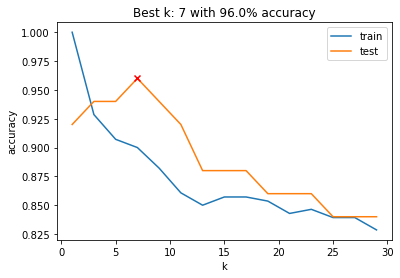

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot mean scores
plt.plot(k_values, mean_tr, label="train")
plt.plot(k_values, mean_te, label="test")

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker="x", c="red", zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te - std_te, mean_te + std_te, alpha=0.2)
plt.title("Best k: {} with {:.1f}% accuracy".format(best_k, 100 * mean_te[best_k]))
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

**Observations:** The k-NN reaches 96% of accuracy with 7 neighbors for this dataset.

#### 3.2. Classification report and confusion matrix
Provide a classification report and visualize the confusion matrix of the test dataset

---

> **Solution**: I use the optimal parameters determined before for computing the classification matrix.

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Tuned k-NN estimator
tuned_knn = Pipeline(
    [("scaler", None), ("knn", KNeighborsClassifier(n_neighbors=best_k))]
)
tuned_knn.fit(X_tr, y_tr)

# Classification report
y_te_preds = tuned_knn.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         9
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         7
           5       1.00      0.80      0.89         5

   micro avg       0.98      0.96      0.97        50
   macro avg       0.99      0.94      0.96        50
weighted avg       0.98      0.96      0.97        50
 samples avg       0.96      0.96      0.96        50



/mnt/data1/Anaconda/envs/adsml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I transform the confusion matrix into a dataframe for having best visualization of the comparison between predicted and true labels.

In [9]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
matrix = confusion_matrix(y_true=y_te.argmax(axis=1), y_pred=y_te_preds.argmax(axis=1))

# Confusion matrix as a DataFrame
matrix_df = pd.DataFrame(
    matrix,
    columns=["pred: bike", "pred: car", "pred: motorcycle", "pred: other", "pred: truck", "pred: van"],
    index=["true: bike", "true: car","true: motorcycle", "true: other", "true: truck", "true: van"],
)

matrix_df

,pred: bike,pred: car,pred: motorcycle,pred: other,pred: truck,pred: van
true: bike,12,0,0,0,0,0
true: car,0,11,0,0,0,0
true: motorcycle,0,0,9,0,0,0
true: other,1,0,0,5,0,0
true: truck,0,0,0,0,7,0
true: van,0,1,0,0,0,4


It can be seen that the only mistakes in the prediction were made with categories other and van, being predicted as bike and car.

#### 3.3. Correctly classified image
Pick an image which was correctly classified in the test set and plot its 10 nearest neighbors from the training set. An example is depicted below

---

> **Solution**: I first get the indices of those images correctly classified, for later get the original images and plot the neighbors around a random correctly-classified image.

In [10]:
preds = y_te_preds.argmax(axis=1)
labels = y_te.argmax(axis=1)
classified = [i for i in range(len(preds)) if preds[i] == labels[i]]

In [11]:
test_good = np.expand_dims(X_te[classified[10],:],axis=0)

In [12]:
neigh = KNeighborsClassifier(n_neighbors=best_k, algorithm="brute")
neigh.fit(X_tr, y_tr)
distances, indices = neigh.kneighbors(test_good, n_neighbors = 10)

In [13]:
indices=(np.squeeze(indices))
distances=(np.squeeze(distances))
distances=(np.round(distances,2))

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from IPython.display import display
import PIL.Image as Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Create image generator
train_generator = ImageDataGenerator(
    rescale=1 / 255)
import os

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join("images", "train"),
    target_size=(224, 224),
    shuffle=False,
    batch_size = 280,
    classes=["bike","car","motorcycle","other","truck","van"]
)

test_generator = ImageDataGenerator(rescale=1. / 255)
# Train, validation and test sets
testset = test_generator.flow_from_directory(
    os.path.join("images", "test"), batch_size = 50,target_size=(224, 224), shuffle=False
)

2022-06-29 12:39:05.568455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 12:39:05.568469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 280 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


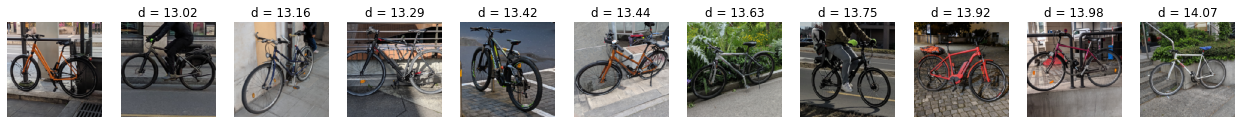

In [15]:

for i in range(0,1):
    img, label = trainset[i]
    img_te,label_te = testset[i]
    rows = 1
    columns = 11
    fig = plt.figure(figsize=(22, 2))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_te[classified[10]])
    plt.axis("off")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img[indices[0]])
    plt.title("d = "+str(distances[0]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(img[indices[1]])
    plt.title("d = "+str(distances[1]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 4)
    plt.imshow(img[indices[2]])
    plt.title("d = "+str(distances[2]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 5)
    plt.imshow(img[indices[3]])
    plt.title("d = "+str(distances[3]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 6)
    plt.imshow(img[indices[4]])
    plt.title("d = "+str(distances[4]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 7)
    plt.imshow(img[indices[5]])
    plt.title("d = "+str(distances[5]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 8)
    plt.imshow(img[indices[6]])
    plt.title("d = "+str(distances[6]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 9)
    plt.imshow(img[indices[7]])
    plt.title("d = "+str(distances[7]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 10)
    plt.imshow(img[indices[8]])
    plt.title("d = "+str(distances[8]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 11)
    plt.imshow(img[indices[9]])
    plt.title("d = "+str(distances[9]))
    plt.axis("off")
    plt.show()

**Observations:**

Is it clear that this image is a bike and the 10 closest images in the feature space are also bikes.

#### 3.4. Incorrectly classified image
Pick an image which was misclassified in the test set and plot its 10 neighbors from the training set

---

> **Solution**: I repeat the process, but now for a misclassified image.

In [16]:
misclassified = [i for i in range(len(preds)) if preds[i] != labels[i]]

In [17]:
test_bad = np.expand_dims(X_te[misclassified[0],:],axis=0)

In [18]:
distances, indices = neigh.kneighbors(test_bad, n_neighbors = 10)

In [19]:
indices=(np.squeeze(indices))
distances=(np.squeeze(distances))
distances=(np.round(distances,2))

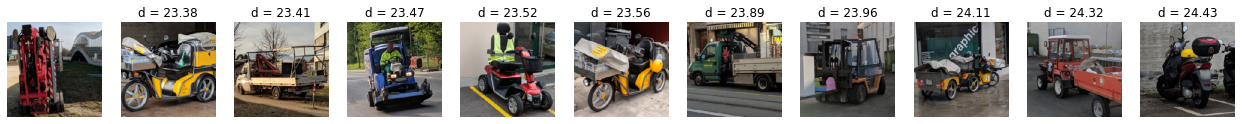

In [20]:
for i in range(0,1):
    img, label = trainset[i]
    img_te,label_te = testset[i]
    rows = 1
    columns = 11
    fig = plt.figure(figsize=(22, 2))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img_te[misclassified[0]])
    plt.axis("off")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img[indices[0]])
    plt.title("d = "+str(distances[0]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(img[indices[1]])
    plt.title("d = "+str(distances[1]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 4)
    plt.imshow(img[indices[2]])
    plt.title("d = "+str(distances[2]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 5)
    plt.imshow(img[indices[3]])
    plt.title("d = "+str(distances[3]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 6)
    plt.imshow(img[indices[4]])
    plt.title("d = "+str(distances[4]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 7)
    plt.imshow(img[indices[5]])
    plt.title("d = "+str(distances[5]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 8)
    plt.imshow(img[indices[6]])
    plt.title("d = "+str(distances[6]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 9)
    plt.imshow(img[indices[7]])
    plt.title("d = "+str(distances[7]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 10)
    plt.imshow(img[indices[8]])
    plt.title("d = "+str(distances[8]))
    plt.axis("off")
    fig.add_subplot(rows, columns, 11)
    plt.imshow(img[indices[9]])
    plt.title("d = "+str(distances[9]))
    plt.axis("off")
    plt.show()

Here we can see that the images closest to the misclassified varies between van, other and motorcycle. This makes the classification process a bit complicated. With more examples of this kind of images the classifier could be improved.